In [32]:
import pandas as pd
import numpy as np
import scipy as sp
import gensim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
%matplotlib inline

In [33]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, matutils


Importing all Presidential speeches and appending them to a dataframe

In [34]:
from os import path
from pathlib import Path
import os
import glob
from collections import defaultdict
root=r'C:\Users\hartg\Desktop\Professional_Projects\Professional-Projects\MSF_Case_Study\Corpus of Presential Speeches\combined'
files=os.listdir(root)

#load speeches into a list

docs=list()
for file in files:
    with open(path.join(root,file),'r',encoding='utf-8') as fd:
        txt=fd.read()
        docs.append(txt)

Function that "cleans" the speeches. Re (regular expression) replaces special characters with, in this case, nothing. This will remove the <title=> characters, etc

In [35]:
import re
def clean(doc):
    doc = re.sub(r'[^\w\s]*','',doc)
    doc = re.sub(r'[\s]+', ' ', doc)
    doc = doc.lower().strip()
    return doc

clean the documents associated with the presidential speeches

In [36]:
clean_docs=list()
for doc in docs:
    doc = clean(doc)
    clean_docs.append(doc)

In [37]:
speeches_df=pd.DataFrame(docs)
speeches_df.columns=['text']

In [38]:
speeches_df.head()

,text
0,"<title=""Special Session Message to Congress"">\..."
1,"<title=""Inaugural Address"">\n<date=""March 4, 1..."
2,"<title=""Second Annual Message"">\n<date=""Decemb..."
3,"<title=""Proclamation of Day of Fasting, Humili..."
4,"<title=""Third Annual Message"">\n<date=""Decembe..."


In [39]:
new_df=speeches_df['text'].str.split("=",n=1,expand=True)
new_df.columns=['title_bad','title_actual']
new_df.head()

,title_bad,title_actual
0,<title,"""Special Session Message to Congress"">\n<date=..."
1,<title,"""Inaugural Address"">\n<date=""March 4, 1797"">\n..."
2,<title,"""Second Annual Message"">\n<date=""December 8, 1..."
3,<title,"""Proclamation of Day of Fasting, Humiliation a..."
4,<title,"""Third Annual Message"">\n<date=""December 3, 17..."


In [40]:
new_df2=new_df['title_actual'].str.split("=",n=1,expand=True)
new_df2.columns=['title','date_and_text']
new_df2.head()

,title,date_and_text
0,"""Special Session Message to Congress"">\n<date","""May 16, 1797"">\nThe personal inconveniences t..."
1,"""Inaugural Address"">\n<date","""March 4, 1797"">\nWhen it was first perceived,..."
2,"""Second Annual Message"">\n<date","""December 8, 1798"">\nGentlemen of the Senate a..."
3,"""Proclamation of Day of Fasting, Humiliation a...","""March 23, 1798"">\nAs the safety and prosperit..."
4,"""Third Annual Message"">\n<date","""December 3, 1799"">\nIt is with peculiar satis..."


In [41]:
new_df3=new_df2['date_and_text'].str.split(">",n=1,expand=True)
new_df3.columns=['date','text']

In [42]:
new_df3.head()

,date,text
0,"""May 16, 1797""",\nThe personal inconveniences to the members o...
1,"""March 4, 1797""","\nWhen it was first perceived, in early times,..."
2,"""December 8, 1798""",\nGentlemen of the Senate and Gentlemen of the...
3,"""March 23, 1798""",\nAs the safety and prosperity of nations ulti...
4,"""December 3, 1799""",\nIt is with peculiar satisfaction that I meet...


In [43]:
speeches=pd.merge(new_df2,new_df3,left_index=True,right_index=True)

In [44]:
speeches.head()

,title,date_and_text,date,text
0,"""Special Session Message to Congress"">\n<date","""May 16, 1797"">\nThe personal inconveniences t...","""May 16, 1797""",\nThe personal inconveniences to the members o...
1,"""Inaugural Address"">\n<date","""March 4, 1797"">\nWhen it was first perceived,...","""March 4, 1797""","\nWhen it was first perceived, in early times,..."
2,"""Second Annual Message"">\n<date","""December 8, 1798"">\nGentlemen of the Senate a...","""December 8, 1798""",\nGentlemen of the Senate and Gentlemen of the...
3,"""Proclamation of Day of Fasting, Humiliation a...","""March 23, 1798"">\nAs the safety and prosperit...","""March 23, 1798""",\nAs the safety and prosperity of nations ulti...
4,"""Third Annual Message"">\n<date","""December 3, 1799"">\nIt is with peculiar satis...","""December 3, 1799""",\nIt is with peculiar satisfaction that I meet...


In [45]:
speeches.drop(['date_and_text'],axis=1,inplace=True)

In [46]:
speeches['title']=speeches.title.str.replace('>\n<date','',regex=True)
speeches.head()

,title,date,text
0,"""Special Session Message to Congress""","""May 16, 1797""",\nThe personal inconveniences to the members o...
1,"""Inaugural Address""","""March 4, 1797""","\nWhen it was first perceived, in early times,..."
2,"""Second Annual Message""","""December 8, 1798""",\nGentlemen of the Senate and Gentlemen of the...
3,"""Proclamation of Day of Fasting, Humiliation a...","""March 23, 1798""",\nAs the safety and prosperity of nations ulti...
4,"""Third Annual Message""","""December 3, 1799""",\nIt is with peculiar satisfaction that I meet...


In [47]:
speeches['date']=speeches.date.str.replace('"','',regex=True)
speeches.head()

,title,date,text
0,"""Special Session Message to Congress""","May 16, 1797",\nThe personal inconveniences to the members o...
1,"""Inaugural Address""","March 4, 1797","\nWhen it was first perceived, in early times,..."
2,"""Second Annual Message""","December 8, 1798",\nGentlemen of the Senate and Gentlemen of the...
3,"""Proclamation of Day of Fasting, Humiliation a...","March 23, 1798",\nAs the safety and prosperity of nations ulti...
4,"""Third Annual Message""","December 3, 1799",\nIt is with peculiar satisfaction that I meet...


In [48]:
speeches['text']=speeches.text.str.replace("\n",'',regex=True)
speeches.head()

,title,date,text
0,"""Special Session Message to Congress""","May 16, 1797",The personal inconveniences to the members of ...
1,"""Inaugural Address""","March 4, 1797","When it was first perceived, in early times, t..."
2,"""Second Annual Message""","December 8, 1798",Gentlemen of the Senate and Gentlemen of the H...
3,"""Proclamation of Day of Fasting, Humiliation a...","March 23, 1798",As the safety and prosperity of nations ultima...
4,"""Third Annual Message""","December 3, 1799",It is with peculiar satisfaction that I meet t...


Dropping indeces 208,801, and 814 as they were not appropriately transformed upon import

In [49]:
speeches.drop([208,801,814],inplace=True)

In [50]:
speeches['date']=pd.to_datetime(speeches['date'])

In [51]:
speeches.set_index('date',inplace=True)


In [52]:
speeches=speeches.loc['1797-05-16':'1849-01-01',:]

In [53]:
speeches['text']=speeches['text'].str.lower()

Loading stopwords from NLTK

In [54]:
from nltk.corpus import stopwords

In [55]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags,strip_punctuation,strip_numeric,stem_text
from gensim.parsing.preprocessing import strip_multiple_whitespaces,strip_non_alphanum,remove_stopwords,strip_short
import pattern
import nltk

In [56]:
Filtering=[lambda x: x.lower(),strip_multiple_whitespaces,
          strip_numeric,
          remove_stopwords,
          strip_short]

In [57]:

def preprocess(text):
    result=[]
    for token in preprocess_string(text,Filtering):
        result.append(token)
    return result
speeches['processed_speech']=speeches['text'].map(preprocess)

In [58]:
lemmatizer=nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return[lemmatizer.lemmatize(w) for w in text]


In [59]:
speeches['processed_speech']=speeches.processed_speech.apply(lemmatize_text)

In [60]:
speeches['bigrams']=speeches.processed_speech.apply(lambda row: list(nltk.ngrams(row,2)))

In [61]:
from gensim import corpora,models,similarities
dictionary=corpora.Dictionary(speeches.processed_speech)

Creating the corpus of documents. Doc2Bow counts the number of occurences of each distinct word and converts the word to an integer word ID. Returns a sparse vector

In [62]:
corpus=[dictionary.doc2bow(text) for text in speeches.processed_speech]

Building a TF-IDF Model (Term Frequency Inverse Document Frequency)

In [63]:
tfidf=models.TfidfModel(corpus)
transformed_tfidf = tfidf[corpus]

LDA (Latent Dirichlet Allocation) on TF-IDF

In [64]:
num_topics=5
%time lda = models.LdaModel(transformed_tfidf,id2word=dictionary,num_topics=num_topics,passes=4,alpha=[.01]*num_topics,eta=[.01]*len(dictionary.keys()))

Wall time: 5.87 s


In [65]:
lda.show_topics()

[(0,
  '0.002*"andwhereas" + 0.001*"oregon" + 0.001*"advice" + 0.001*"van" + 0.001*"unlawful" + 0.001*"welfare"" + 0.001*"buren.by" + 0.001*"states.m." + 0.001*"president:forsyth,secretary" + 0.001*"file"'),
 (1,
  '0.003*"mexico" + 0.002*"texas" + 0.002*"said" + 0.002*"british" + 0.002*"mexico," + 0.002*"mexican" + 0.002*"war" + 0.002*"service" + 0.002*"indian" + 0.001*"military"'),
 (2,
  '0.002*"cherokee" + 0.001*"brothers," + 0.001*"gun-boats" + 0.001*"choctaw" + 0.001*"association," + 0.001*"delegate" + 0.001*"bank" + 0.001*"tribe." + 0.001*"tribe," + 0.001*"presents."'),
 (3,
  '0.002*"federal" + 0.002*"bank" + 0.002*"opinion" + 0.002*"france" + 0.002*"note" + 0.002*"french" + 0.002*"public" + 0.002*"union" + 0.002*"construction" + 0.002*"people"'),
 (4,
  '0.002*"bank" + 0.002*"public" + 0.002*"treaty" + 0.002*"year" + 0.002*"treasury" + 0.002*"improvement" + 0.002*"power" + 0.002*"report" + 0.002*"money" + 0.002*"relation"')]

In [66]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda,corpus,dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.135863  0.083738       1        1  55.318855
1      0.126421  0.085875       2        1  27.690550
3     -0.011763 -0.103756       3        1  16.814539
2      0.006720 -0.032681       4        1   0.121716
0      0.014485 -0.033176       5        1   0.054335, topic_info=               Term        Freq       Total Category  logprob  loglift
4597           bank  407.000000  407.000000  Default  30.0000  30.0000
5893       governor  134.000000  134.000000  Default  29.0000  29.0000
1080         indian  188.000000  188.000000  Default  28.0000  28.0000
796       territory  173.000000  173.000000  Default  27.0000  27.0000
10518      proposal   77.000000   77.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
796       territory    0.092511  173.723038   Topic5  -7.2563  -0.0201
3974   proclamation    0.081205   33.948769   Topic5  -7.3867   1.4821
12637         james    0.081231   68.447739   Topic5  -7.3864   0.7812
925         british    0.078921  276.943268   Topic5  -7.4152  -0.6454
3156      judgment,    0.077120   23.968237   Topic5  -7.4383   1.7786

[366 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
11943      1  0.607956  "make
11943      2  0.303978  "make
11943      3  0.303978  "make
3986       1  0.922670    $,,
3986       2  0.035487    $,,
...      ...       ...    ...
1321       2  0.888763   you,
1321       3  0.023700   you,
6472       1  0.461084  young
6472       2  0.230542  young
6472       3  0.230542  young

[993 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

In [67]:
count = 1
for doc in speeches['processed_speech']:
    vec=dictionary.doc2bow(doc)
    print("Speech # ",count, lda[vec])
    count=count+1

Speech #  1 [(1, 0.357717), (3, 0.1612247), (4, 0.48103756)]
Speech #  2 [(1, 0.27012065), (3, 0.21013787), (4, 0.5197131)]
Speech #  3 [(1, 0.27176765), (3, 0.41275504), (4, 0.31538495)]
Speech #  4 [(1, 0.34088433), (3, 0.13166527), (4, 0.52741176)]
Speech #  5 [(1, 0.4555946), (3, 0.090007536), (4, 0.4543697)]
Speech #  6 [(1, 0.5969743), (3, 0.120940916), (4, 0.28202158)]
Speech #  7 [(1, 0.7512455), (3, 0.022401007), (4, 0.22617418)]
Speech #  8 [(1, 0.29050708), (3, 0.11866649), (4, 0.59078425)]
Speech #  9 [(1, 0.25691697), (3, 0.23968801), (4, 0.50338656)]
Speech #  10 [(1, 0.25964475), (3, 0.30018163), (4, 0.44011799)]
Speech #  11 [(1, 0.19443819), (2, 0.071697325), (3, 0.17061003), (4, 0.5632175)]
Speech #  12 [(1, 0.71838707), (3, 0.046878938), (4, 0.23462531)]
Speech #  13 [(1, 0.18274355), (3, 0.26964962), (4, 0.5475951)]
Speech #  14 [(1, 0.24696364), (3, 0.17645413), (4, 0.576576)]
Speech #  15 [(1, 0.3406792), (3, 0.30643043), (4, 0.35283682)]
Speech #  16 [(1, 0.21604

Speech #  131 [(1, 0.2471128), (3, 0.16310938), (4, 0.58977)]
Speech #  132 [(1, 0.11770293), (3, 0.022142723), (4, 0.8600718)]
Speech #  133 [(1, 0.18539451), (3, 0.09294755), (4, 0.721649)]
Speech #  134 [(1, 0.26550472), (3, 0.16815063), (4, 0.56633663)]
Speech #  135 [(1, 0.15575628), (3, 0.0804132), (4, 0.7637928)]
Speech #  136 [(1, 0.21452285), (3, 0.2885488), (4, 0.49688885)]
Speech #  137 [(1, 0.27403107), (3, 0.26251993), (4, 0.46341798)]
Speech #  138 [(1, 0.48645782), (3, 0.103524365), (4, 0.40601745)]
Speech #  139 [(1, 0.16830868), (3, 0.053720463), (4, 0.77791303)]
Speech #  140 [(1, 0.2666364), (3, 0.18369989), (4, 0.54965687)]
Speech #  141 [(1, 0.20699324), (3, 0.23016049), (4, 0.5628406)]
Speech #  142 [(1, 0.34880966), (3, 0.25663403), (4, 0.39453813)]
Speech #  143 [(0, 0.16087602), (1, 0.416975), (3, 0.04909728), (4, 0.37298825)]
Speech #  144 [(1, 0.24376264), (3, 0.16440797), (4, 0.59182376)]
Speech #  145 [(0, 0.12138729), (1, 0.40755826), (3, 0.07963244), (4, 

In [68]:
t=0
for i in lda.show_topics(num_topics=num_topics, num_words=5, log=False, formatted=True):
    print ("Topic # ", t , i)
    t = t + 1

Topic #  0 (0, '0.002*"andwhereas" + 0.001*"oregon" + 0.001*"advice" + 0.001*"van" + 0.001*"unlawful"')
Topic #  1 (1, '0.003*"mexico" + 0.002*"texas" + 0.002*"said" + 0.002*"british" + 0.002*"mexico,"')
Topic #  2 (2, '0.002*"cherokee" + 0.001*"brothers," + 0.001*"gun-boats" + 0.001*"choctaw" + 0.001*"association,"')
Topic #  3 (3, '0.002*"federal" + 0.002*"bank" + 0.002*"opinion" + 0.002*"france" + 0.002*"note"')
Topic #  4 (4, '0.002*"bank" + 0.002*"public" + 0.002*"treaty" + 0.002*"year" + 0.002*"treasury"')


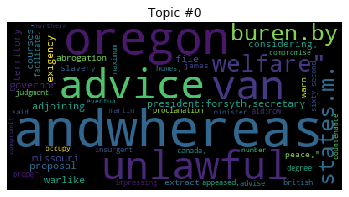

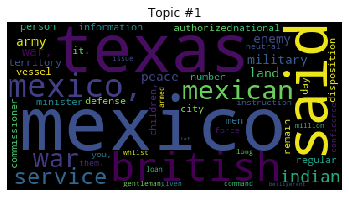

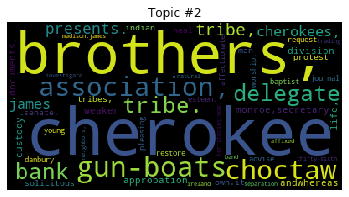

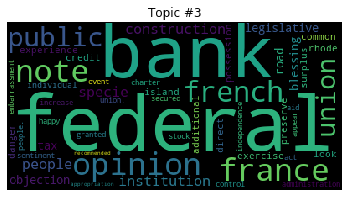

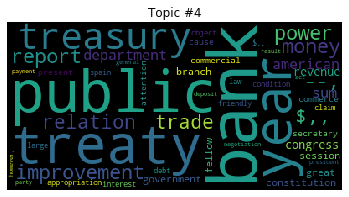

In [69]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t,50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [70]:
topics = [lda[corpus[i]] for i in range(len(speeches))]

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res
document_topic=\
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

Text(33.0, 0.5, 'Speech')

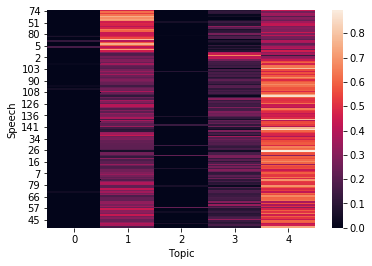

In [71]:
import seaborn as sns
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])
plt.xlabel('Topic')
plt.ylabel('Speech')

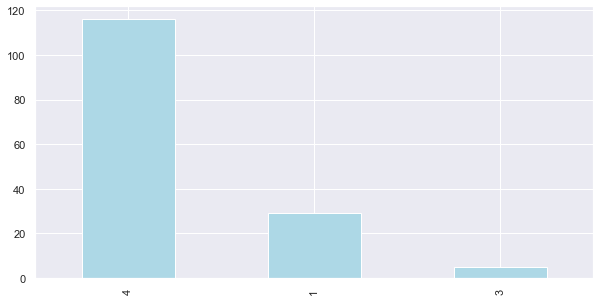

In [72]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')